In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet34

## Hyperparameters

In [3]:
DEVICE = "cuda"
IMG_SIZE = (224, 224)
IMG_ROOT = '/home/advattack/imagenet/ILSVRC_KAGGLE/five_one/'

## Filtering Transformation

In [4]:
from PIL import Image
import scipy.ndimage
import numpy as np
import torch

class ToNumpy:
    """Convert data to numpy array"""
    def __call__(self, x):
        if isinstance(x, Image.Image):
            x = np.array(x)
        elif isinstance(x, torch.Tensor):
            x = x.numpy()
        return x
    
class MaxFilter:
    def __init__(self, size):
        self.size = size
        
    def __call__(self, x):
        return scipy.ndimage.maximum_filter(x, self.size)

In [5]:
# Filtering Operation
OP = T.Compose([
    ToNumpy(),
    MaxFilter(size=5),
    T.ToPILImage(),
])

# Clean Forward Transform
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Forward Transform
op_transform = T.Compose([
    OP,
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Backward Transform
inverse = T.Compose([
    T.Normalize(mean=[0., 0., 0.],
                std=[1/0.229, 1/0.224, 1/0.225]),
    T.Normalize(mean=[-0.485, -0.456, -0.406],
                std=[1., 1., 1.]),
    T.ToPILImage()
])

## Dataset

In [6]:
dataset = ImageFolder(root=IMG_ROOT, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

op_dataset = ImageFolder(root=IMG_ROOT, transform=op_transform)
op_dataloader = DataLoader(op_dataset, batch_size=1, shuffle=False)

## Load Pretrained Resnet18

In [7]:
model = resnet18(pretrained=True)
model = model.to(DEVICE)
model = model.eval()

## Check answers

In [8]:
answers1 = []
answers2 = []

for imgs, labels in dataloader:
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)   
    outputs = model(imgs)
    preds = torch.max(outputs, 1)[1].item()
    answers1.append(preds)
    
for imgs, labels in op_dataloader:
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(imgs)
    preds = torch.max(outputs, 1)[1].item()
    answers2.append(preds)
    
collision = np.array(answers1) == np.array(answers2)
ratio = np.sum(collision)/len(collision)
print("Same Ratio:", ratio)

Same Ratio: 0.6


## Hyperparameter Find

In [9]:
MAX_SIZES = np.linspace(0, 5, 5)

In [10]:
overlap_ratios = []

for target_size in MAX_SIZES:
    # Filtering Operation
    OP = T.Compose([
        ToNumpy(),
        MaxFilter(size=target_size),
        T.ToPILImage(),
    ])

    # Clean Forward Transform
    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # Forward Transform
    op_transform = T.Compose([
        OP,
        T.Resize(256),
        T.CenterCrop(IMG_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(root=IMG_ROOT, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    op_dataset = ImageFolder(root=IMG_ROOT, transform=op_transform)
    op_dataloader = DataLoader(op_dataset, batch_size=1, shuffle=False)

    answers1 = []
    answers2 = []

    for imgs, labels in dataloader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)   
        outputs = model(imgs)
        preds = torch.max(outputs, 1)[1].item()
        answers1.append(preds)

    for imgs, labels in op_dataloader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        preds = torch.max(outputs, 1)[1].item()
        answers2.append(preds)

    collision = np.array(answers1) == np.array(answers2)
    ratio = np.sum(collision)/len(collision)
    overlap_ratios.append(ratio)

Text(0, 0.5, 'Same Ratio')

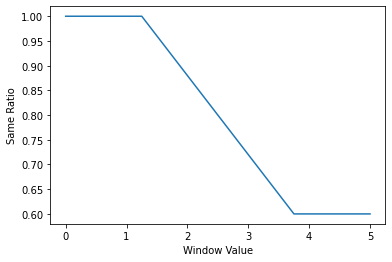

In [11]:
plt.plot(MAX_SIZES, overlap_ratios)
plt.xlabel('Window Value')
plt.ylabel('Same Ratio')

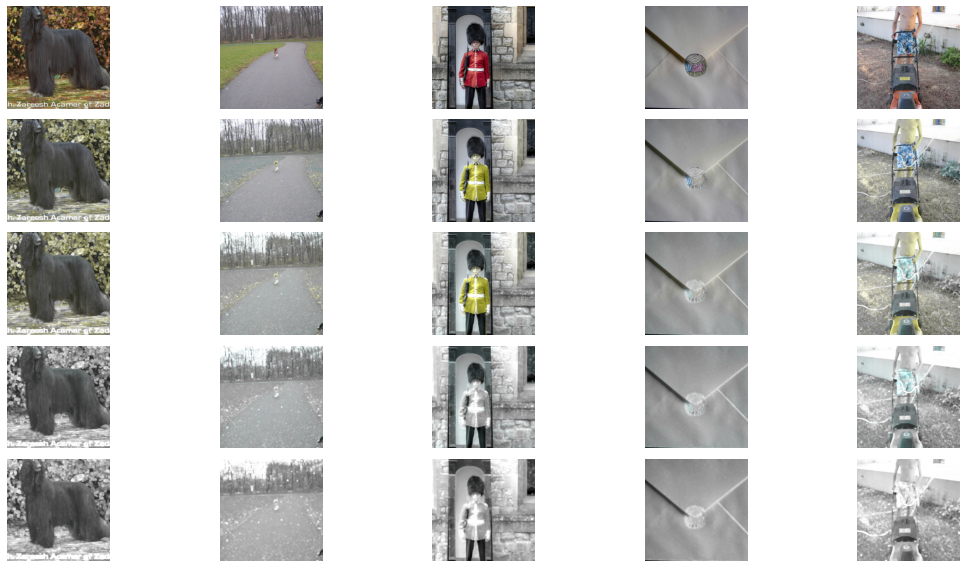

In [13]:
SIZES = [1,2,3,4,5]

fig, axes = plt.subplots(len(SIZES), 5, figsize=(16, 8))

for i in range(len(SIZES)):
    OP = T.Compose([
            ToNumpy(),
            MaxFilter(size=SIZES[i]),
            T.ToPILImage(),
        ])
    transform = T.Compose([
            OP,
            T.Resize(256),
            T.CenterCrop(IMG_SIZE),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
    dataset = ImageFolder(root=IMG_ROOT, transform=transform)
    for j, (img, label) in enumerate(dataset):
        img = np.array(inverse(img))
        axes[i][j].imshow(img)
        axes[i][j].set_axis_off()
        
plt.tight_layout()